In [1]:
%load_ext autoreload
%autoreload 2

Using simpler models with the same results. Can this be considered a victory?

In [2]:
import sys
import os
import pandas as pd
import shap
import csv
sys.path.append(os.path.abspath(os.path.join('..')))
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report

from utility.classification_utility import *

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's start by building our beautiful dataset

In [3]:
cyc = '../dataset/cyclists_cleaned.csv'
races = '../dataset/races_cleaned.csv'
df = make_dataset_for_classification(races, cyc, make_stage_type=True)

100.00%  


In [4]:
# dumb imputations
df['height'] = df['height'].fillna(df['height'].mean())
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['bmi'] = df['weight']/np.square(df['height']/100)
df['cyclist_age_rac'] = df['cyclist_age_rac'].fillna(df['cyclist_age_rac'].mean())
df['climb_total'] = df['climb_total'].fillna(df['length']*0.05) # could be differentiated by lengths
df['steepness'] = df['length'] / df['climb_total']

In [5]:
# for profile, let's use the big stick
df['is_ITT'] = (df['stage_type'] == 'ITT').astype(int)
df_filtered = df[['length', 'climb_total', 'steepness', 'average_speed', 'is_ITT', 'profile']].dropna()
X = df_filtered[['length', 'climb_total', 'steepness', 'average_speed', 'is_ITT']]
y = df_filtered['profile']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
y_pred = clf.predict(X_test)
print(f"Accuracy: {np.mean(y_pred == y_test)}")
print(f"Feature importance: {clf.feature_importances_}")

Accuracy: 0.9991312777770783
Feature importance: [0.21644605 0.27903885 0.30263699 0.20187812 0.        ]


Well.. this might mean that the inferences over the climb total and the length were quite accurate

In [7]:
# Predict missing profiles
missing_profiles = df[df['profile'].isna()]
df.loc[missing_profiles.index, 'profile'] = clf.predict(missing_profiles[['length', 'climb_total', 'steepness', 'average_speed', 'is_ITT']])

In [8]:
TO_USE_COLS = [
    # over time
    'total_points',
    'avg_points_per_race', 
    'average_position',
    'avg_speed_cyclist', 
    'mean_stamina_index',
    'race_count',
    'average_position_var',
    # race related
    'length',
    'climb_total', 
    'profile', 
    'startlist_quality', 
    'cyclist_age_rac', 
    'steepness', 
    'is_tarmac', 
    'stage_type',
    'season',
    'partecipants_number',
    # cyclist related
    'height',
    'weight',
    'bmi',
    'home_game',
    # for the split
    'date',
    'target'
]

df_to_use = df[TO_USE_COLS]

In [9]:
# useless
# season_dummies = pd.get_dummies(df['season'], prefix='season')
# df_to_use = pd.concat([df_to_use.drop(columns=['season']), season_dummies], axis=1)

one_hot encoding season gave no sensible results. As expected, the feature remains quite uninsightful

In [10]:
df_tr, df_vl, df_ts = get_data_split(df_to_use)

df_tr = df_tr.drop(columns=['date'])
df_vl = df_vl.drop(columns=['date'])
df_ts = df_ts.drop(columns=['date'])

X_tr, y_tr = split_features_target(df_tr)
X_vl, y_vl = split_features_target(df_vl)
X_ts, y_ts = split_features_target(df_ts)

Normalize the features before predicting

In [11]:
scal = StandardScaler()
X_tr = scal.fit_transform(X_tr)
X_vl = scal.transform(X_vl)
X_ts = scal.transform(X_ts)

# Nn test

This is a funny tool for later

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_recall',  
    monitor='val_loss',
    patience=8,            
    mode='max',            
    restore_best_weights=True  
)

Let's build this model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_tr.shape[1],)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Lion()


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[
    'accuracy',
    'recall'
    ])

Now fit it

In [23]:
history = model.fit(
    X_tr, y_tr, 
    validation_data=(X_vl, y_vl), 
    epochs=10, 
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/10
5550/5550 - 3s - 586us/step - accuracy: 0.8510 - loss: 0.3759 - recall: 0.0750 - val_accuracy: 0.8578 - val_loss: 0.3460 - val_recall: 0.0619
Epoch 2/10
5550/5550 - 3s - 498us/step - accuracy: 0.8540 - loss: 0.3683 - recall: 0.0745 - val_accuracy: 0.8583 - val_loss: 0.3440 - val_recall: 0.0457
Epoch 3/10
5550/5550 - 3s - 494us/step - accuracy: 0.8539 - loss: 0.3687 - recall: 0.0726 - val_accuracy: 0.8594 - val_loss: 0.3460 - val_recall: 0.1533
Epoch 4/10
5550/5550 - 3s - 493us/step - accuracy: 0.8542 - loss: 0.3683 - recall: 0.0789 - val_accuracy: 0.8583 - val_loss: 0.3432 - val_recall: 0.0435
Epoch 5/10
5550/5550 - 3s - 492us/step - accuracy: 0.8547 - loss: 0.3678 - recall: 0.0813 - val_accuracy: 0.8595 - val_loss: 0.3443 - val_recall: 0.0810
Epoch 6/10
5550/5550 - 3s - 496us/step - accuracy: 0.8542 - loss: 0.3685 - recall: 0.0818 - val_accuracy: 0.8578 - val_loss: 0.3439 - val_recall: 0.0390
Epoch 7/10
5550/5550 - 3s - 494us/step - accuracy: 0.8547 - loss: 0.3678 - recall:

In [24]:
val_pred = model.predict(X_vl)
val_pred = (val_pred > 0.5).astype(int)
report = classification_report(y_vl, val_pred)
print(report)

1359/1359 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
              precision    recall  f1-score   support

       False       0.88      0.97      0.92     37243
        True       0.54      0.19      0.28      6237

    accuracy                           0.86     43480
   macro avg       0.71      0.58      0.60     43480
weighted avg       0.83      0.86      0.83     43480



# Grid Search

In [13]:
dict_learning = {
    'adam': tf.keras.optimizers.Adam(),
    'sgd': tf.keras.optimizers.SGD(),
    'lion': tf.keras.optimizers.Lion()
}

def build_model(num_layers=2, num_units=64, optimizer='adam', activation='relu', dropout=0.2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_tr.shape[1],)))
    
    model.add(tf.keras.layers.Dense(num_units, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout))
    
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(num_units, activation=activation))
        model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    opt = dict_learning[optimizer]
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'recall'])
    return model

param_grid = {
    'num_layers': [1, 2],
    'num_units': [32, 64],
    'optimizer': ['adam', 'sgd', 'lion'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [5],
} # already passed through this

This proto grid search has already been ran over various parameters. Without verbosity. Won't be uploading on git a long version of the last.

Nothing much changes between these different hyperparameters. Maybe the answer lies elsewhere, like in regularization: oversampling and dropout?

In [15]:
param_grid = {
    'dropout': [0.2, 0.5],
    'num_layers': [2, 3],
    'num_units': [64, 128, 256],
    'optimizer': ['adam'],
    'activation': ['relu'],
    'batch_size': [32,64],
    # 'batch_norm': [True], # useless
    'epochs': [10],
}

In [14]:
ratio = 0.35
# oversample = RandomOverSampler(sampling_strategy=ratio, random_state=42) # same results as SMOTE
oversample = SMOTE(sampling_strategy=ratio, random_state=42)
oversampled_X, oversampled_y = oversample.fit_resample(X_tr, y_tr)

Over the different trials, SMOTE gave no sensible difference from usual random oversampling.

In [ ]:
param_list = list(ParameterSampler(param_grid, n_iter=650, random_state=42))

for params in param_list:
    print(f"Training model with parameters: {params}")
    model = build_model(params['num_layers'], params['num_units'], params['optimizer'], params['activation'], params['dropout'])
    history = model.fit(
        oversampled_X, oversampled_y, 
        validation_data=(X_vl, y_vl), 
        epochs=params['epochs'], 
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[early_stopping]
    )
    val_pred = model.predict(X_vl)
    val_pred = (val_pred > 0.5).astype(int)
    
    # write metrics and params in a file
    with open('model_eval.txt', 'a') as f:
        f.write(f"Parameters: {params}, oversampled: {ratio}\n")
        f.write(classification_report(y_vl, val_pred))
        f.write('\n\n')


In [ ]:
param_list = list(ParameterSampler(param_grid, n_iter=650, random_state=42))

# Initialize CSV file if not exists
csv_file = 'model_eval.csv'
write_header = not os.path.exists(csv_file)

# Loop through each parameter set and train the model
for params in param_list:
    print(f"Training model with parameters: {params}")
    model = build_model(params['num_layers'], params['num_units'], params['optimizer'], params['activation'], params['dropout'])
    history = model.fit(
        oversampled_X, oversampled_y, 
        validation_data=(X_vl, y_vl), 
        epochs=params['epochs'], 
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[early_stopping]
    )
    val_pred = model.predict(X_vl)
    val_pred = (val_pred > 0.5).astype(int)
    
    # Generate classification report as a DataFrame
    report = classification_report(y_vl, val_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Add model parameters to the DataFrame
    for param, value in params.items():
        report_df[param] = value
    report_df['oversampled_ratio'] = ratio
    
    # Append DataFrame to the CSV file
    if write_header:
        report_df.to_csv(csv_file, mode='w', index_label='class')
        write_header = False  # Write header only for the first iteration
    else:
        report_df.to_csv(csv_file, mode='a', header=False, index_label='class')


Oversampling boosts recall to good levels but mutilates precision, while dropout does the opposite. Tuning them seems the best option <br>
Two layers and more units seem to improve a bit the overall metrics. <br>
As professor Micheli said, I have to listen to the neural network and move where it tells me.  <br>
Also, early stopping and more epochs might help. Maybe let's reduce the parameters.

In [16]:
# get dataset from csv in model_eval.csv
report = pd.read_csv('model_eval.csv')
# keep only the macro average
report = report[report['class'] == 'macro avg']

In [17]:
report.describe()

,precision,recall,f1-score,support,num_units,num_layers,epochs,dropout,batch_size,oversampled_ratio
count,686.000000,686.000000,686.000000,686.0,686.000000,686.000000,686.000000,686.000000,686.000000,6.860000e+02
mean,0.669621,0.633308,0.640793,43480.0,86.950437,2.056851,7.638484,0.346939,37.784257,3.500000e-01
std,0.051181,0.042142,0.047943,0.0,91.879549,0.888518,2.497983,0.150078,19.850245,1.111033e-16
min,0.428271,0.499946,0.461341,43480.0,32.000000,1.000000,5.000000,0.200000,16.000000,3.500000e-01
25%,0.658352,0.620992,0.636285,43480.0,32.000000,1.000000,5.000000,0.200000,16.000000,3.500000e-01
50%,0.679860,0.643531,0.653522,43480.0,64.000000,2.000000,10.000000,0.200000,32.000000,3.500000e-01
75%,0.692327,0.660365,0.668538,43480.0,128.000000,3.000000,10.000000,0.500000,64.000000,3.500000e-01
max,0.846577,0.705601,0.691875,43480.0,1024.000000,7.000000,10.000000,0.500000,64.000000,3.500000e-01


In [18]:
report.sort_values(by='f1-score', ascending=False)

,class,precision,recall,f1-score,support,optimizer,num_units,num_layers,epochs,dropout,batch_size,activation,oversampled_ratio
3408,macro avg,0.685562,0.699111,0.691875,43480.0,adam,256,5,10,0.2,32,relu,0.35
3268,macro avg,0.689402,0.690235,0.689817,43480.0,adam,256,3,10,0.2,32,relu,0.35
3388,macro avg,0.685603,0.694322,0.689771,43480.0,adam,1024,2,10,0.2,64,relu,0.35
3318,macro avg,0.684407,0.692612,0.688338,43480.0,adam,64,3,10,0.2,64,relu,0.35
3373,macro avg,0.684719,0.688570,0.686607,43480.0,adam,512,3,10,0.2,32,relu,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,macro avg,0.428277,0.500000,0.461368,43480.0,lion,128,3,10,0.5,16,relu,0.35
1078,macro avg,0.428277,0.500000,0.461368,43480.0,lion,128,3,10,0.5,32,relu,0.35
523,macro avg,0.428277,0.500000,0.461368,43480.0,lion,64,3,10,0.5,16,relu,0.35
373,macro avg,0.428277,0.500000,0.461368,43480.0,lion,32,3,5,0.5,16,relu,0.35


All in all, it seems to be mostly about initialization and not falling in bad local minima. A good balance of dropout and oversampling managed to get us up to `0.68` of f1-score. Maybe, with better features, we could have achieved more. Minimal results are reached incrementing the number of units and layers... this means just add more of them! <br>
Update: adding batch normalization and more layers helped us get an increment of... 1%! Well, better than nothing

In [20]:
param_grid = {
    'dropout': [0.2],
    'num_layers': [6,7],
    'num_units': [256],
    'optimizer': ['adam'],
    'activation': ['relu'],
    'batch_size': [32],
    # 'batch_norm': [True], # useless
    'epochs': [10],
}

def build_model(num_layers=2, num_units=64, optimizer='adam', activation='relu', dropout=0.2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_tr.shape[1],)))
    
    model.add(tf.keras.layers.Dense(num_units))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    model.add(tf.keras.layers.Dropout(dropout))
    
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(num_units))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation))
        model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'recall'])
    return model

In [ ]:
param_list = list(ParameterSampler(param_grid, n_iter=650, random_state=42))

# Initialize CSV file if not exists
csv_file = 'model_eval.csv'
write_header = not os.path.exists(csv_file)

# Loop through each parameter set and train the model
for params in param_list:
    print(f"Training model with parameters: {params}")
    model = build_model(params['num_layers'], params['num_units'], params['optimizer'], params['activation'], params['dropout'])
    history = model.fit(
        oversampled_X, oversampled_y, 
        validation_data=(X_vl, y_vl), 
        epochs=params['epochs'], 
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[early_stopping]
    )
    val_pred = model.predict(X_vl)
    val_pred = (val_pred > 0.5).astype(int)
    
    # Generate classification report as a DataFrame
    report = classification_report(y_vl, val_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Add model parameters to the DataFrame
    for param, value in params.items():
        report_df[param] = value
    report_df['oversampled_ratio'] = ratio
    
    # Append DataFrame to the CSV file
    if write_header:
        report_df.to_csv(csv_file, mode='w', index_label='class')
        write_header = False  # Write header only for the first iteration
    else:
        report_df.to_csv(csv_file, mode='a', header=False, index_label='class')


# Explanability

Let's see what can we infer from applying some explanability to these models! So far we don't move past 0.68, no matter what we do. Maybe shap can give us some insights

In [19]:
shap.initjs()

In [21]:
winnable = build_model(num_units=256, num_layers=5)
winnable.fit(oversampled_X, oversampled_y, 
        validation_data=(X_vl, y_vl), 
        epochs=20,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
        )

Epoch 1/20
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.7635 - loss: 0.4964 - recall: 0.3092 - val_accuracy: 0.8456 - val_loss: 0.3757 - val_recall: 0.4331
Epoch 2/20
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.7774 - loss: 0.4708 - recall: 0.3481 - val_accuracy: 0.8471 - val_loss: 0.3659 - val_recall: 0.4549
Epoch 3/20
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.7792 - loss: 0.4666 - recall: 0.3534 - val_accuracy: 0.8490 - val_loss: 0.3730 - val_recall: 0.4395
Epoch 4/20
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.7811 - loss: 0.4636 - recall: 0.3644 - val_accuracy: 0.8507 - val_loss: 0.3622 - val_recall: 0.4464
Epoch 5/20
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.7833 - loss: 0.4614 - recall: 0.3679 - val_accuracy: 0.8494 - val_loss: 0.3647 - val_recall: 0.4456
Epoch 6/20
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.7828 - loss: 0.4603 - recall: 0.3751 - val_accuracy: 0.8489 - val_loss: 0.

In [22]:
# make X_vl into a DataFrame
X_df_vl = pd.DataFrame(X_vl, columns=df_tr.columns[:21])

In [23]:
sample_to_train = shap.sample(X_df_vl, 50)

In [24]:
def f(X):
    return winnable.predict(X).flatten()

In [25]:
# explain a bunch of predictions using shap

explainer = shap.KernelExplainer(f, sample_to_train.iloc[:50])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [ ]:
shap_values = explainer.shap_values(X_df_vl.iloc[:100,:], nsamples=400)

In [29]:
shap.force_plot(explainer.expected_value, shap_values, X_df_vl.iloc[:100,:])

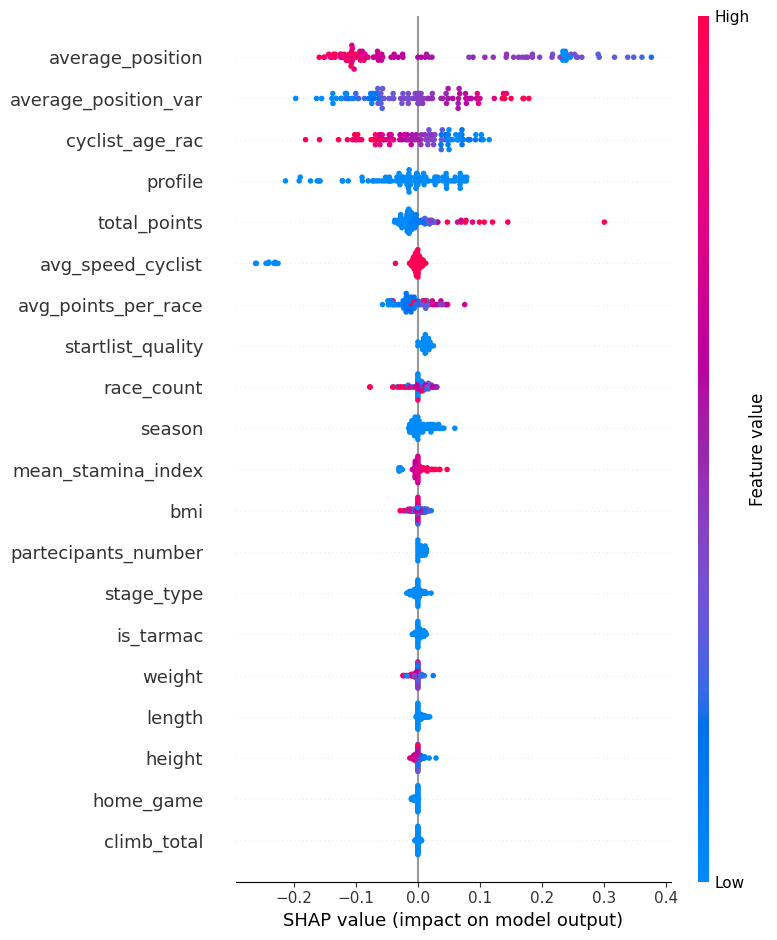

In [30]:
shap.summary_plot(shap_values, X_df_vl.iloc[:100,:])

As can be seen from the force plot and the summary plot, we have something to talk about!

`average_position`, `cyclist_age_rac` and `profile`:
- These features have the most significant impact on the model's output, with SHAP values distributed widely.
- Different values of these features strongly influence predictions, as indicated in the plot.
- As we might have expected, statistics that might give an insight on the preceding positions of the cyclists are used a lot by our algorithm. Maybe, the standard deviation of it and other transformations might have given some more edge to our models
- As it seems, an higher age (at race time!) implies less chances to win a race. Intuitively, this can be seen as cyclists having more chances to get good positions when they are in their "prime" instead of when they hit the 50 years of age.
- It seems the profile of a race highly influences whether a cyclist will arrive on the podium or not! This might mean that there are a lot of cyclists that are more inclined to win certain races than others.
- *Update!* We added the variance of the position for a given cyclist `average_position_var` but to not great avail, albeit it's given a lot of importance by our model 

`avg_points_per_race` and `total_points`:
- These features also play a critical role but have slightly less variance in their SHAP values compared to the top features. These general statistics about how fructuous a cyclist performances are help the model infer its possible position more than the mere race count.

`avg_speed_cyclist`:
- This feature seems moderately important, with a noticeable spread around the center for very high values and very skewed values for the lowest values. It's difficult to get to the finish line first if on average you are slow.

`race_count`, `startlist_quality`, `mean_stamina_index` and `weight`:
- These have limited impact compared to other features but still contribute marginally. It seems that, for this model, heavier cyclists have a harder time winning.

Minor Features:
- Features such as `bmi`, `height`, `home_game`, and `steepness` have a minimal impact on the model, as indicated by their tightly clustered SHAP values around zero.